In [ ]:
import pandas as pd
import numpy as np

# Generate synthetic quarterly data for 5 years
np.random.seed(42)
dates = pd.date_range(start='2018-01-01', end='2022-12-31', freq='Q')

# Create base trend with seasonality and some noise
n_quarters = len(dates)
trend = np.linspace(1000000, 2500000, n_quarters)  # Upward trend
seasonal = 200000 * np.sin(np.linspace(0, 5*2*np.pi, n_quarters))  # Seasonal pattern
noise = np.random.normal(0, 50000, n_quarters)  # Random noise

# Combine components
ltv_values = trend + seasonal + noise

# Create DataFrame
quarterly_data = pd.DataFrame({
    'ds': dates,
    'y': ltv_values
})

# Apply log transformation to handle exponential trends
quarterly_data['y'] = np.log1p(quarterly_data['y'])

# Create copy for modeling
data = quarterly_data.copy()

# Visualize the synthetic data
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], marker='o', linestyle='-')
plt.title('Synthetic Quarterly Customer LTV')
plt.xlabel('Date')
plt.ylabel('Log-transformed LTV')
plt.grid(True)
plt.show()

## Time Series Forecasting of Next-Quarter LTV

In this notebook, we use synthetic quarterly LTV data to create quarterly LTV data based on generated values.
We then:
- Build a forecasting model using Prophet
- Build a forecasting model using ARIMA
- Forecast the next quarter's LTV
- Evaluate both models using MAE and RMSE

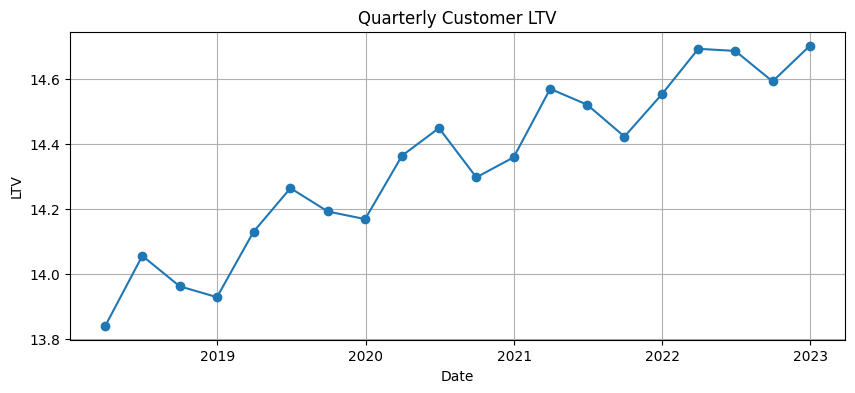

02:25:10 - cmdstanpy - INFO - Chain [1] start processing


Training data:
           ds          y
14 2021-09-30  14.423026
15 2021-12-31  14.553228
16 2022-03-31  14.693641
17 2022-06-30  14.687112
18 2022-09-30  14.593153 

Test data:
           ds          y
19 2022-12-31  14.703149


02:25:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast for next quarter: 14.66


/opt/anaconda3/envs/Deepseek_local/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


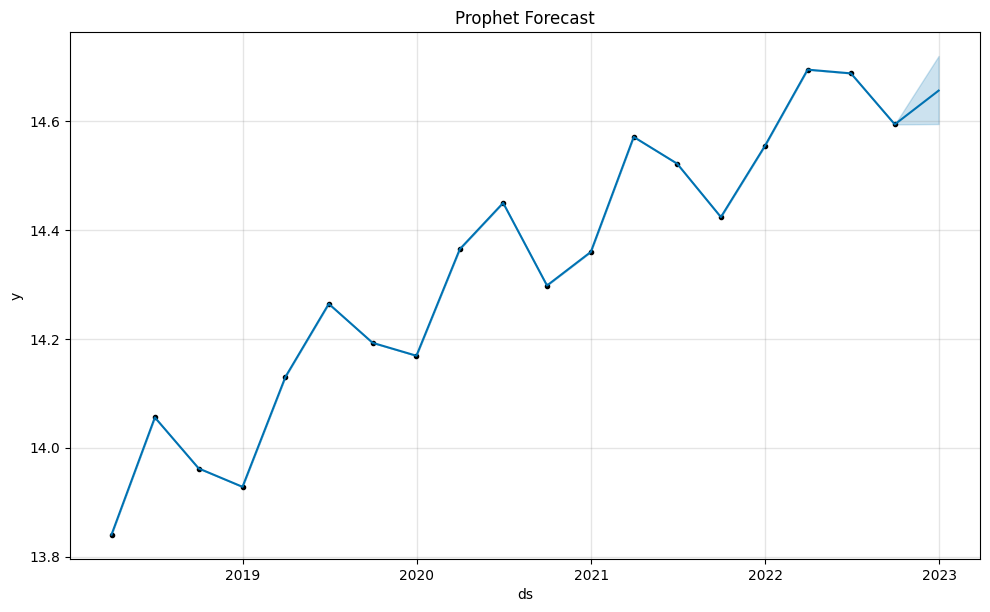

ADF Statistic: 0.0785302357898044
p-value: 0.964564312250057


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Prophet forecasting
from prophet import Prophet

# For ARIMA modeling
from statsmodels.tsa.arima.model import ARIMA

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualize the data
plt.figure(figsize=(10, 4))
plt.plot(data['ds'], data['y'], marker='o', linestyle='-')
plt.title('Quarterly Customer LTV')
plt.xlabel('Date')
plt.ylabel('LTV')
plt.grid(True)
plt.show()

### Train-Test Split
For evaluation, we hold out the last quarter as our test set and use the remaining data for training.

In [ ]:
train = data.iloc[:-1].copy()
test = data.iloc[-1:].copy()

print("Training data:")
print(train.tail(), "\n")
print("Test data:")
print(test)

### Forecasting with Prophet
We fit the Prophet model on the training data and forecast the next quarter.

In [ ]:
# Modify Prophet parameters
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# Initialize and fit Prophet model
prophet_model.fit(train)

# Create a future dataframe for one period (next quarter)
future = prophet_model.make_future_dataframe(periods=1, freq='Q')
forecast = prophet_model.predict(future)

# Extract the forecasted value for the next quarter
prophet_pred = forecast[forecast['ds'] == test['ds'].iloc[0]]['yhat'].values[0]
print(f"Prophet forecast for next quarter: {prophet_pred:.2f}")

# Plot Prophet forecast
prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

### Forecasting with ARIMA
We fit an ARIMA model on the training data using auto_arima for parameter selection.

In [ ]:
# Check stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(train['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Find optimal ARIMA parameters
from pmdarima import auto_arima

# Fit auto_arima
auto_model = auto_arima(train['y'],
                       start_p=0, start_q=0, max_p=3, max_q=3, m=4,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)

print("Best ARIMA params:", auto_model.order)

# Use the optimal parameters for ARIMA
arima_model = ARIMA(train['y'], order=auto_model.order).fit()

# Forecast next quarter (1 step ahead)
arima_forecast = arima_model.forecast(steps=1).values[0]
print(f"ARIMA forecast for next quarter: {arima_forecast:.2f}")

### Model Evaluation
With the actual LTV for the test quarter, we compute the evaluation metrics (MAE and RMSE) for each model.

Since our test set has one data point, these errors reflect the absolute deviation for that quarter.

In [ ]:
# Transform predictions back to original scale
prophet_pred = np.expm1(prophet_pred)
arima_forecast = np.expm1(arima_forecast)
actual = np.expm1(test['y'].values[0])

# Calculate evaluation metrics for Prophet
mae_prophet = mean_absolute_error([actual], [prophet_pred])
rmse_prophet = np.sqrt(mean_squared_error([actual], [prophet_pred]))

# Calculate evaluation metrics for ARIMA
mae_arima = mean_absolute_error([actual], [arima_forecast])
rmse_arima = np.sqrt(mean_squared_error([actual], [arima_forecast]))

# Display results
results = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'Forecast': [prophet_pred, arima_forecast],
    'Actual': [actual, actual],
    'MAE': [mae_prophet, mae_arima],
    'RMSE': [rmse_prophet, rmse_arima]
})

print(results)

### Comparison & Conclusion

The table above shows the forecasted LTV for the next quarter and the corresponding MAE and RMSE for both models.
In practice, you would choose the model with lower error metrics. Note that performance on one test point may not be
statistically significant, so consider cross-validation or a longer hold-out period if more data is available.